## ETL on `OpenPowerlifting` Data

In [2]:
from IPython.display import display, Markdown
import polars as pl 
from datetime import datetime as dt

# read configs 
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))
from steps import conf

### Loading Data

In [3]:
s3_file_path = f"https://{conf.bucket_name}.s3.ap-southeast-2.amazonaws.com/{conf.parquet_file}"

df = pl.read_parquet(s3_file_path)
df.head(5)

Name,Sex,Event,Equipment,Age,AgeClass,BirthYearClass,Division,BodyweightKg,WeightClassKg,Squat1Kg,Squat2Kg,Squat3Kg,Squat4Kg,Best3SquatKg,Bench1Kg,Bench2Kg,Bench3Kg,Bench4Kg,Best3BenchKg,Deadlift1Kg,Deadlift2Kg,Deadlift3Kg,Deadlift4Kg,Best3DeadliftKg,TotalKg,Place,Dots,Wilks,Glossbrenner,Goodlift,Tested,Country,State,Federation,ParentFederation,Date,MeetCountry,MeetState,MeetTown,MeetName
str,str,str,str,f64,str,str,str,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,str,str,str,str,str,str,str,str,str,str
"""Alona Vladi""","""F""","""SBD""","""Raw""",33.0,"""24-34""","""24-39""","""O""",58.3,"""60""",75.0,80.0,-90.0,null,80.0,50.0,55.0,60.0,null,60.0,95.0,105.0,107.5,null,107.5,247.5,"""1""",279.44,282.18,249.42,57.1,"""Yes""","""Russia""",null,"""GFP""",null,"""2019-05-11""","""Russia""",null,"""Bryansk""","""Open Tournamen…"
"""Galina Solovya…","""F""","""SBD""","""Raw""",43.0,"""40-44""","""40-49""","""M1""",73.1,"""75""",95.0,100.0,105.0,null,105.0,62.5,67.5,-72.5,null,67.5,100.0,110.0,-120.0,null,110.0,282.5,"""1""",278.95,272.99,240.35,56.76,"""Yes""","""Russia""",null,"""GFP""",null,"""2019-05-11""","""Russia""",null,"""Bryansk""","""Open Tournamen…"
"""Daniil Voronin…","""M""","""SBD""","""Raw""",15.5,"""16-17""","""14-18""","""T""",67.4,"""75""",85.0,90.0,100.0,null,100.0,55.0,62.5,-65.0,null,62.5,90.0,100.0,105.0,null,105.0,267.5,"""1""",206.4,206.49,200.45,41.24,"""Yes""","""Russia""",null,"""GFP""",null,"""2019-05-11""","""Russia""",null,"""Bryansk""","""Open Tournamen…"
"""Aleksey Krasov…","""M""","""SBD""","""Raw""",35.0,"""35-39""","""24-39""","""O""",66.65,"""75""",125.0,132.0,137.5,null,137.5,115.0,122.5,-127.5,null,122.5,150.0,165.0,170.0,null,170.0,430.0,"""1""",334.49,334.94,325.32,66.68,"""Yes""","""Russia""",null,"""GFP""",null,"""2019-05-11""","""Russia""",null,"""Bryansk""","""Open Tournamen…"
"""Margarita Ples…","""M""","""SBD""","""Raw""",26.5,"""24-34""","""24-39""","""O""",72.45,"""75""",80.0,85.0,90.0,null,90.0,40.0,50.0,-60.0,null,50.0,112.5,120.0,125.0,null,125.0,265.0,"""1""",194.46,193.55,187.29,39.34,"""Yes""","""Russia""",null,"""GFP""",null,"""2019-05-11""","""Russia""",null,"""Bryansk""","""Open Tournamen…"


In [4]:
cleansing_data_md = f"""
## Cleansing data
- Filter for only particular columns from {conf.op_cols}
    - Select events that are IPF / Tested federations only (i.e. `Tested` = "Yes")
    - Remove anyone who has been disqualified (i.e. `Place` = "DQ")
    - `raw` equipment events only (i.e. `equipment` = `Raw`, single ply and wraps have 'competitive' advantage and are typically only for advanced lifters)
- Drop any rows that have missing values in the columns above.
- Drop any duplicates based on all columns.
"""

display(Markdown(cleansing_data_md))


## Cleansing data
- Filter for only particular columns from ['Date', 'Name', 'Sex', 'Place', 'Age', 'AgeClass', 'BodyweightKg', 'Event', 'MeetCountry', 'Equipment', 'Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg', 'TotalKg', 'Wilks', 'Tested', 'Federation', 'MeetName']
    - Select events that are IPF / Tested federations only (i.e. `Tested` = "Yes")
    - Remove anyone who has been disqualified (i.e. `Place` = "DQ")
    - `raw` equipment events only (i.e. `equipment` = `Raw`, single ply and wraps have 'competitive' advantage and are typically only for advanced lifters)
- Drop any rows that have missing values in the columns above.
- Drop any duplicates based on all columns.


In [5]:
base_df = df.select(conf.op_cols)
print(base_df.shape)
base_df.head(5)

(2903147, 18)


Date,Name,Sex,Place,Age,AgeClass,BodyweightKg,Event,MeetCountry,Equipment,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Wilks,Tested,Federation,MeetName
str,str,str,str,f64,str,f64,str,str,str,f64,f64,f64,f64,f64,str,str,str
"""2019-05-11""","""Alona Vladi""","""F""","""1""",33.0,"""24-34""",58.3,"""SBD""","""Russia""","""Raw""",80.0,60.0,107.5,247.5,282.18,"""Yes""","""GFP""","""Open Tournamen…"
"""2019-05-11""","""Galina Solovya…","""F""","""1""",43.0,"""40-44""",73.1,"""SBD""","""Russia""","""Raw""",105.0,67.5,110.0,282.5,272.99,"""Yes""","""GFP""","""Open Tournamen…"
"""2019-05-11""","""Daniil Voronin…","""M""","""1""",15.5,"""16-17""",67.4,"""SBD""","""Russia""","""Raw""",100.0,62.5,105.0,267.5,206.49,"""Yes""","""GFP""","""Open Tournamen…"
"""2019-05-11""","""Aleksey Krasov…","""M""","""1""",35.0,"""35-39""",66.65,"""SBD""","""Russia""","""Raw""",137.5,122.5,170.0,430.0,334.94,"""Yes""","""GFP""","""Open Tournamen…"
"""2019-05-11""","""Margarita Ples…","""M""","""1""",26.5,"""24-34""",72.45,"""SBD""","""Russia""","""Raw""",90.0,50.0,125.0,265.0,193.55,"""Yes""","""GFP""","""Open Tournamen…"


In [6]:
cleansed_df = base_df.filter(
    (pl.col("Event") == "SBD") & 
    (pl.col("Tested") == "Yes") & 
    (pl.col('Place').apply(lambda x: x.isnumeric(), return_dtype = pl.Boolean)) & 
    (pl.col("Equipment") == "Raw")
).drop_nulls().unique().sort("Date", descending=True).drop(["Tested", "Federation", "Event"])
print(cleansed_df.shape)
cleansed_df.head(5)

(427224, 15)


Date,Name,Sex,Place,Age,AgeClass,BodyweightKg,MeetCountry,Equipment,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Wilks,MeetName
str,str,str,str,f64,str,f64,str,str,f64,f64,f64,f64,f64,str
"""2023-04-30""","""Matyas Kovach""","""M""","""1""",41.0,"""40-44""",73.85,"""USA""","""Raw""",180.0,132.5,185.0,497.5,358.37,"""Tri-State Cham…"
"""2023-04-30""","""Amanda Lairmor…","""F""","""1""",23.5,"""24-34""",50.4,"""USA""","""Raw""",160.0,77.5,120.0,357.5,456.49,"""MetroEast Rook…"
"""2023-04-30""","""Wendolyn Reyes…","""F""","""2""",21.5,"""20-23""",103.1,"""USA""","""Raw""",150.0,75.0,175.0,400.0,330.22,"""MetroEast Rook…"
"""2023-04-30""","""Mikaela Inskee…","""F""","""3""",19.5,"""20-23""",59.2,"""USA""","""Raw""",92.5,65.0,125.0,282.5,318.26,"""MetroEast Rook…"
"""2023-04-30""","""Alexis Novak""","""F""","""4""",21.5,"""20-23""",62.8,"""USA""","""Raw""",90.0,55.0,102.5,247.5,266.45,"""MetroEast Rook…"


In [7]:
cleansed_df.filter(pl.col("Name") == "John Paul Cauchi").sort("Date", descending=True).head(5)

Date,Name,Sex,Place,Age,AgeClass,BodyweightKg,MeetCountry,Equipment,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Wilks,MeetName
str,str,str,str,f64,str,f64,str,str,f64,f64,f64,f64,f64,str
"""2022-11-05""","""John Paul Cauc…","""M""","""1""",29.5,"""24-34""",82.35,"""Australia""","""Raw""",265.0,137.5,290.0,692.5,464.42,"""Ballarat Open"""
"""2021-04-11""","""John Paul Cauc…","""M""","""1""",28.0,"""24-34""",76.75,"""Australia""","""Raw""",260.0,138.0,290.0,688.0,482.56,"""JPS Open VII"""
"""2020-09-26""","""John Paul Cauc…","""M""","""2""",27.5,"""24-34""",76.95,"""Australia""","""Raw""",256.0,133.0,306.0,695.0,486.62,"""Australian Pow…"
"""2019-08-22""","""John Paul Cauc…","""M""","""2""",26.5,"""24-34""",76.9,"""China""","""Raw""",248.0,135.0,273.0,656.0,459.52,"""Asia Pacific O…"
"""2019-06-28""","""John Paul Cauc…","""M""","""1""",26.5,"""24-34""",76.85,"""Australia""","""Raw""",253.0,134.0,286.0,673.0,471.63,"""Australian Pow…"


## Data Preparation
- Drop the `Tested`, `Federation` and `Event` columns as they are no longer needed.
- Update column types: 
    - `Date` to `Date`
    - `Place` to `Int64`
- Collect data from 2000-01-01 onwards. 
- Rename columns from camel to snake case 
- Assume that a powerlifter's country is from the first country that compete in. 

In [8]:
# find the first country that the powerlifter competed in and assume that is their country of origin
lifter_country_df = cleansed_df.groupby(["Name", "Sex"]).agg(pl.first("MeetCountry").alias("OriginCountry"))

In [11]:
data_prep_df = cleansed_df.sort(["Name", "Date"], descending=[False, True]).join(lifter_country_df, on=["Name", "Sex"]).filter(pl.col("Date").gt("2000-01-01")).with_columns(
    pl.col("Date").str.strptime(pl.Date, fmt="%Y-%m-%d").alias("Date"),
    pl.col("Place").cast(pl.Int32).alias("Place"),
).rename(
    mapping=conf.op_cols_rename
).select(
    pl.all().map_alias(lambda col_name: conf.camel_to_snake(col_name))
)


print(data_prep_df.shape)
data_prep_df.head(5)

(426396, 16)


date,name,sex,place,age,age_class,bodyweight,meet_country,equipment,squat,bench,deadlift,total,wilks,meet_name,origin_country
date,str,str,i32,f64,str,f64,str,str,f64,f64,f64,f64,f64,str,str
2017-12-04,"""A Ajeesha""","""F""",1,16.5,"""16-17""",71.1,"""India""","""Raw""",112.5,55.0,132.5,300.0,295.29,"""Asian Classic …","""India"""
2012-12-10,"""A Ashwin""","""M""",1,16.5,"""16-17""",82.55,"""India""","""Raw""",170.0,95.0,220.0,485.0,324.79,"""Asian Classic …","""India"""
2019-10-01,"""A Belousov""","""M""",8,17.5,"""18-19""",73.6,"""Kazakhstan""","""Raw""",75.0,75.0,100.0,250.0,180.52,"""Kazakhstan Cla…","""Kazakhstan"""
2019-09-26,"""A K S Shri Ram…","""M""",13,16.0,"""16-17""",78.2,"""India""","""Raw""",117.5,50.0,150.0,317.5,219.95,"""Indian Classic…","""India"""
2019-09-26,"""A Pradeep""","""M""",6,17.0,"""16-17""",80.7,"""India""","""Raw""",150.0,97.5,170.0,417.5,283.48,"""Indian Classic…","""India"""


### Feature Engineering
- Create a `pot_*` (progress over time) columns for `wilks` and `total`
- Adds columns:
  - `time_since_last_comp`: identify how long it has been since their last competition (in days)
  - `home_country`: 1 if `meet_country` == `origin_country` else 0 
  - `bodyweight_change`: change in bodyweight since the last comp (in kg)
  - `cumulative_comps`: running total of the number of comopetitions completed
  - `meet_type`: categories each meet in `local`, `national` or `international`
- Switches `Date` to ordinal as a new column `date_ass_ordinal`

In [70]:
fe_df = data_prep_df.with_columns(
     (pl.col('date') - pl.col('date').shift(-1)).over('name').alias('time_since_last_comp').apply(lambda x: x.days).cast(pl.Int32),
     (pl.col('bodyweight') - pl.col('bodyweight').shift(-1)).over('name').alias('bodyweight_change').cast(pl.Float64),
).sort(
    ["name", "date"], descending=[False, False]
).with_columns(
    (pl.col('time_since_last_comp') / 365.25).alias('years_since_last_comp'),
    (pl.col("meet_country") == pl.col("origin_country")).alias("is_origin_country"),
    pl.col('date').apply(lambda x: x.toordinal()).alias('date_as_ordinal'),
    pl.col('name').cumcount().over('name').alias('cumulative_comps'),
    pl.when(
        pl.col("meet_name").str.contains('national')
    ).then("national").otherwise(
    pl.when(
        pl.col('meet_name').str.contains('International|World|Commonwealth')
    ).then("international").otherwise("local")).alias('meet_type')
)


fe_df = fe_df.with_columns(
    ((pl.col('squat') - pl.col('squat').shift(1)) / pl.col('years_since_last_comp')).over('name').alias(f'squat_progress'),
    ((pl.col('bench') - pl.col('bench').shift(1)) / pl.col('years_since_last_comp')).over('name').alias(f'bench_progress'),
    ((pl.col('deadlift') - pl.col('deadlift').shift(1)) / pl.col('years_since_last_comp')).over('name').alias(f'deadlift_progress'),
    ((pl.col('total') - pl.col('total').shift(1)) / pl.col('years_since_last_comp')).over('name').alias(f'total_progress'),
    ((pl.col('wilks') - pl.col('wilks').shift(1)) / pl.col('years_since_last_comp')).over('name').alias(f'wilks_progress')
).drop_nulls()


In [71]:
jp_df = fe_df.filter(pl.col('name').is_in(["Nam Tonthat"]))
jp_df.to_pandas().to_markdown

<bound method DataFrame.to_markdown of         date         name sex  place   age age_class  bodyweight meet_country   
0 2022-09-17  Nam Tonthat   M      1  28.5     24-34        69.9    Australia  \
1 2022-12-03  Nam Tonthat   M      4  28.5     24-34        66.6    Australia   

  equipment  squat  ...  years_since_last_comp  is_origin_country   
0       Raw  140.0  ...               1.434634               True  \
1       Raw  147.5  ...               0.210815               True   

   date_as_ordinal  cumulative_comps meet_type squat_progress  bench_progress   
0           738415                 1     local       0.000000        1.394084  \
1           738492                 2  national      35.576299       11.858766   

   deadlift_progress  total_progress  wilks_progress  
0           6.970420        8.364504       -0.285787  
1          35.576299       83.011364      126.367013  

[2 rows x 28 columns]>

## Visualisation

In [102]:
import altair as alt 
import seaborn as sns

numerical_cols = [
    "age", 
    "bodyweight", 
    "bodyweight_change",
    "time_since_last_comp",
    "cumulative_comps",
    "total"
]

fe_df_numerical = fe_df.select(pl.col(numerical_cols)).sample(5000).to_pandas()

correlation_df = fe_df_numerical.corr()

<Axes: >

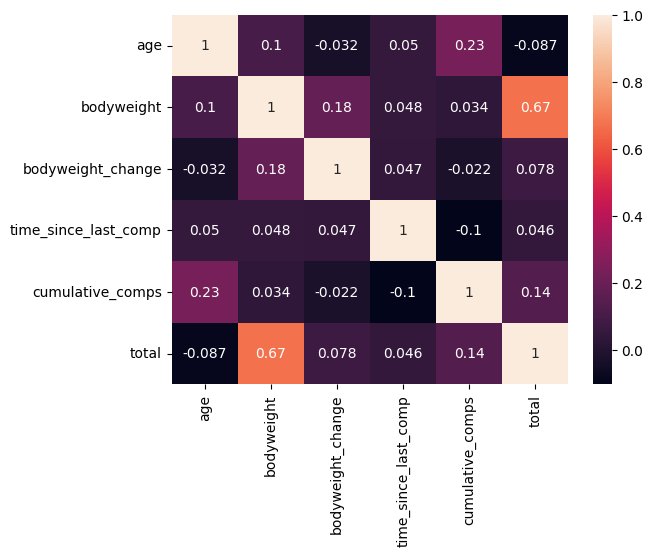

In [103]:
sns.heatmap(correlation_df, annot=True)

In [96]:

# Create a scatter plot for each feature against 'total'
plots = [
    alt.Chart(fe_df_numerical).mark_circle().encode(
        x=alt.X(f'{feature}:Q', title=feature),
        y=alt.Y('total:Q', title='Total'),
        tooltip=[feature, 'total']
    ).properties(
        width=200,
        height=200,
        title=f'Total vs {feature}'
    )
    for feature in numerical_cols
]

In [97]:
alt.hconcat(*plots)

alt.HConcatChart(...)

## Modelling

In [67]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [68]:
param_grid = {
    'regressor__bootstrap': [True],
    'regressor__max_depth': [80, 90, 100, 110],
    'regressor__max_features': [2, 3],
    'regressor__min_samples_leaf': [3, 4, 5],
    'regressor__min_samples_split': [8, 10, 12],
    'regressor__n_estimators': [100, 200, 300, 1000]
}


In [69]:
fe_df.schema

{'date': Date,
 'name': Utf8,
 'sex': Utf8,
 'place': Int32,
 'age': Float64,
 'age_class': Utf8,
 'bodyweight': Float64,
 'meet_country': Utf8,
 'equipment': Utf8,
 'squat': Float64,
 'bench': Float64,
 'deadlift': Float64,
 'total': Float64,
 'wilks': Float64,
 'meet_name': Utf8,
 'origin_country': Utf8,
 'time_since_last_comp': Int32,
 'bodyweight_change': Float64,
 'years_since_last_comp': Float64,
 'is_origin_country': Boolean,
 'date_as_ordinal': Int64,
 'cumulative_comps': UInt32,
 'meet_type': Utf8}

In [269]:
features = [
    "date_as_ordinal", "name", "sex", "age", "age_class", "bodyweight", "equipment", "total", "place", "time_since_last_comp", "squat_progress", "bench_progress", "deadlift_progress", "total_progress", "wilks_progress", "origin_country", "is_origin_country", "meet_type", "cumulative_comps","bodyweight_change"
]

target = [
    "total"
]


# Preprocessing steps for numeric features
numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

# Preprocessing steps for categorical features
categorical_transformer = Pipeline([
    ('encoder', OneHotEncoder())
])


# Preprocessing steps for label encoded features
ordinal_transformer = Pipeline([
    ('encoder', OrdinalEncoder())
])

# Combine preprocessing steps for all features
preprocessor = ColumnTransformer([
    ('numeric', numeric_transformer, ['age', 'bodyweight','time_since_last_comp', "squat_progress", "bench_progress", "deadlift_progress", "total_progress", "wilks_progress", 'date_as_ordinal', 'total', 'bodyweight_change', 'cumulative_comps']),
    ('categorical', categorical_transformer, ['sex', 'is_origin_country']),
    ('ordinal', ordinal_transformer, ['place', 'name', 'age_class', 'origin_country', 'meet_type'])
])

# Create the pipeline with preprocessing steps and the regressor
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

In [291]:
fe_df = data_prep_df.with_columns(
     (pl.col('date') - pl.col('date').shift(-1)).over('name').alias('time_since_last_comp').apply(lambda x: x.days).cast(pl.Int32)
).filter(pl.col("name") == "A. Belevskiy")

In [294]:
fe_df.tail(2).to_dict(as_series=True)

{'date': shape: (2,)
 Series: 'date' [date]
 [
 	2015-10-05
 	2015-10-05
 ],
 'name': shape: (2,)
 Series: 'name' [str]
 [
 	"A. Belevskiy"
 	"A. Belevskiy"
 ],
 'sex': shape: (2,)
 Series: 'sex' [str]
 [
 	"M"
 	"M"
 ],
 'place': shape: (2,)
 Series: 'place' [i32]
 [
 	1
 	4
 ],
 'age': shape: (2,)
 Series: 'age' [f64]
 [
 	16.5
 	16.5
 ],
 'age_class': shape: (2,)
 Series: 'age_class' [str]
 [
 	"16-17"
 	"16-17"
 ],
 'bodyweight': shape: (2,)
 Series: 'bodyweight' [f64]
 [
 	94.35
 	96.0
 ],
 'meet_country': shape: (2,)
 Series: 'meet_country' [str]
 [
 	"Kazakhstan"
 	"Kazakhstan"
 ],
 'equipment': shape: (2,)
 Series: 'equipment' [str]
 [
 	"Raw"
 	"Single-ply"
 ],
 'squat': shape: (2,)
 Series: 'squat' [f64]
 [
 	200.0
 	250.0
 ],
 'bench': shape: (2,)
 Series: 'bench' [f64]
 [
 	142.5
 	150.0
 ],
 'deadlift': shape: (2,)
 Series: 'deadlift' [f64]
 [
 	210.0
 	240.0
 ],
 'total': shape: (2,)
 Series: 'total' [f64]
 [
 	552.5
 	640.0
 ],
 'wilks': shape: (2,)
 Series: 'wilks' [f64

In [282]:
fe_df.filter(pl.col("name") == 'A. Belevskiy')

date,name,sex,place,age,age_class,bodyweight,meet_country,equipment,squat,bench,deadlift,total,wilks,meet_name,origin_country,time_since_last_comp,squat_progress,bench_progress,deadlift_progress,total_progress,wilks_progress,is_origin_country,date_as_ordinal
date,str,str,i32,f64,str,f64,str,str,f64,f64,f64,f64,f64,str,str,i32,f64,f64,f64,f64,f64,bool,i64
2016-07-04,"""A. Belevskiy""","""M""",1,17.5,"""18-19""",97.2,"""Kazakhstan""","""Single-ply""",235.0,172.5,235.0,642.5,395.64,"""Kazakhstan Sub…","""Kazakhstan""",93,4.455852,5.092402,1.909651,11.457906,5.135688,true,736149
2016-04-02,"""A. Belevskiy""","""M""",1,17.5,"""18-19""",98.65,"""Kazakhstan""","""Raw""",212.5,147.5,215.0,575.0,351.88,"""Kazakhstan Cla…","""Kazakhstan""",31,1.909651,2.121834,1.697467,5.728953,3.714059,true,736056
2016-03-02,"""A. Belevskiy""","""M""",1,17.5,"""18-19""",97.45,"""Kazakhstan""","""Single-ply""",235.0,160.0,230.0,625.0,384.45,"""Kazakhstan Pow…","""Kazakhstan""",149,-9.178645,-5.099247,-6.119097,-20.396988,-13.286598,true,736025
2015-10-05,"""A. Belevskiy""","""M""",1,16.5,"""16-17""",94.35,"""Kazakhstan""","""Raw""",200.0,142.5,210.0,552.5,344.75,"""Kazakhstan Pow…","""Kazakhstan""",0,0.0,0.0,0.0,0.0,0.0,true,735876


In [270]:
X_train, X_test, y_train, y_test = train_test_split(fe_df[features], fe_df[target], test_size=0.2, random_state=42)

In [271]:
pipeline.fit(X_train.to_pandas(), y_train.to_pandas())

/Users/namtonthat/Library/Caches/pypoetry/virtualenvs/powerlifting-ml-progress-4gf5U7T4-py3.11/lib/python3.11/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bodyweight',
                                                   'time_since_last_comp',
                                                   'squat_progress',
                                                   'bench_progress',
                                                   'deadlift_progress',
                                                   'total_progress',
                                                   'wilks_progress',
                                                   'date_as_ordinal',
                                                   'total']),
                                                 ('categorical',
                                                 

In [ ]:
# Initialize the grid search model
grid_search = GridSearchCV(estimator = pipeline, param_grid = param_grid, 
                           cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search model
grid_search.fit(X_train.to_pandas(), y_train.to_pandas())

# Get the best parameters
best_params = grid_search.best_params_

# Train the model using the best parameters
best_model = RandomForestRegressor(**best_params)
best_model.fit(X_train.to_pandas(), y_train.to_pandas())

# Make predictions
y_pred = best_model.predict(X_test.to_pandas())


In [ ]:
print(f"Mean Squared Error: {mse}")